### 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

### Importing Libraries for Data Loading

In [32]:
from sklearn.datasets import fetch_openml

In [33]:
wages = fetch_openml(data_id=534, as_frame=True)

### Exploring the Dataset
Displaying the first few rows of the dataset to understand its structure and features.

In [34]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

### Importing Analysis Libraries and Tools
Importing necessary libraries for:
- Machine learning models and pipelines
- Data preprocessing and transformation
- Model evaluation and feature importance
- Data visualization and numerical operations

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy.special import exp10

#### Flow of Pipeline creation 
- I will analyse the data and decide which predictors to choose. I will keep the target variable 'WAGE' in y variable.
- I will shuffle and then split the data into train and test subsets. (test size : 30% ) 
- I will create the transformers, feature selectors and will incorporate them inside my Pipeline
- My final estimator should be Ridge regression. Using GridSearchCV  I will choose the optimal alpha value.

##### Data Analysis and Visualization
Creating a heatmap to visualize correlations between numerical variables and a pairplot to see relationships between all variables.

<Axes: >

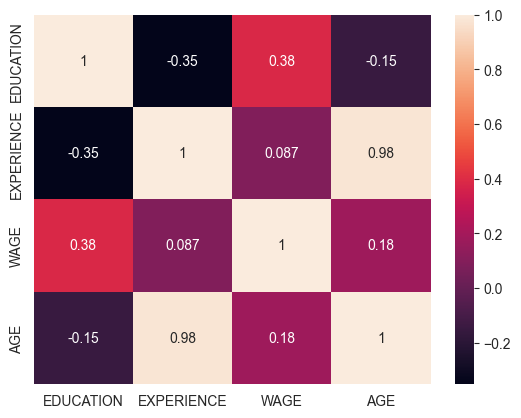

In [36]:
sns.heatmap(wages.frame.corr(numeric_only=True), annot = True)

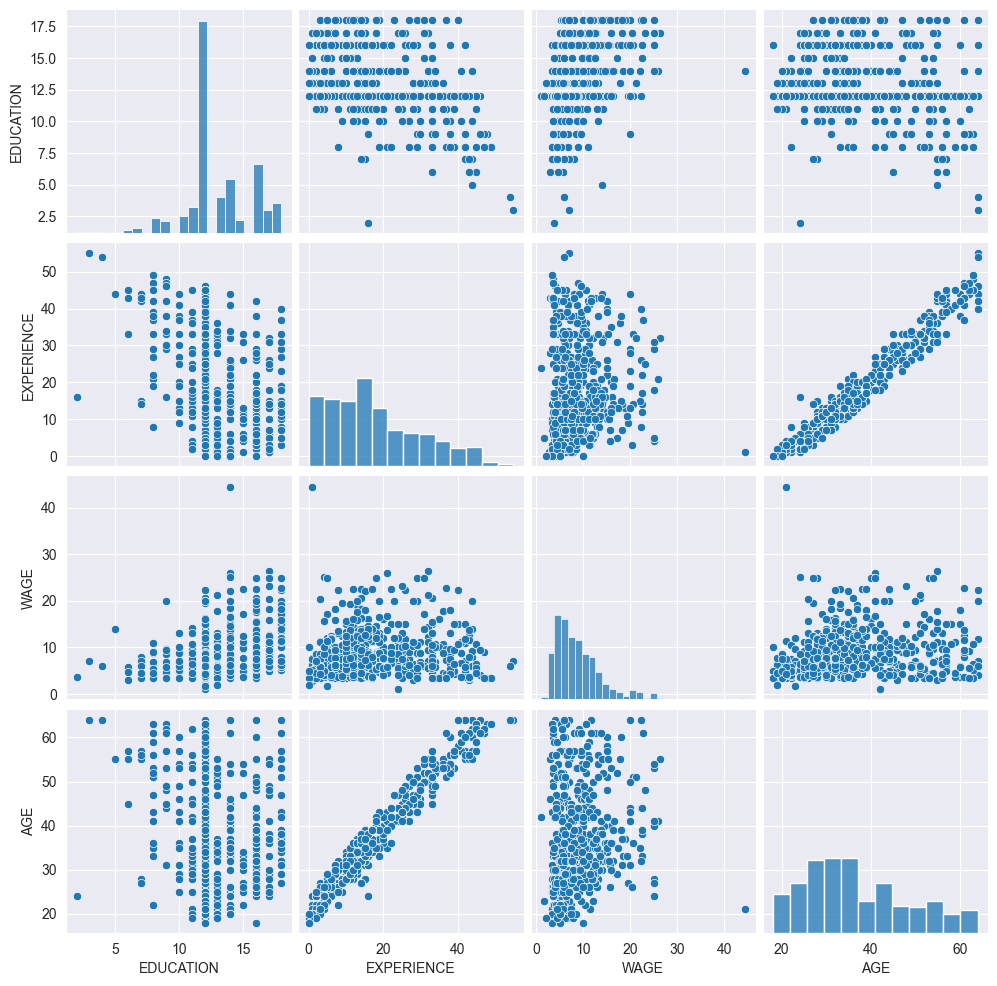

In [37]:
sns.pairplot(wages.frame)

### Distribution Analysis
Wage is left skewed. To tackle the skewness we could log-transform it. Also, EXPERIENCE should be dropped as there is a matter of multicollinearity with AGE.

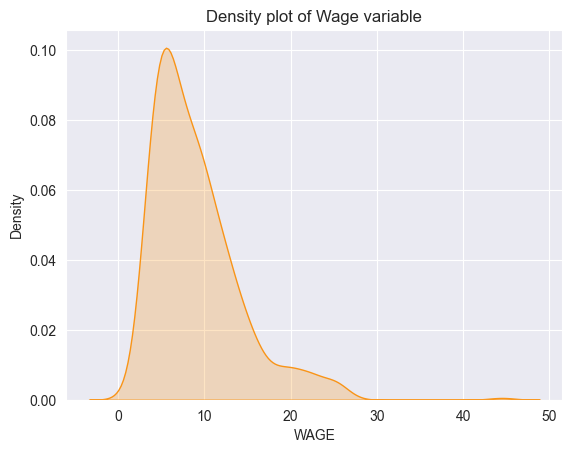

In [38]:
plt.title('Density plot of Wage variable')
sns.kdeplot(data = wages.frame.WAGE, fill = True, color = '#F99417');

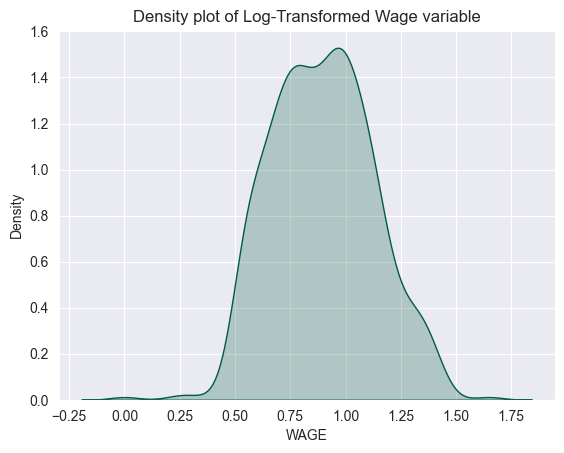

In [39]:
plt.title('Density plot of Log-Transformed Wage variable')
sns.kdeplot(data = np.log10(wages.frame.WAGE), fill = True, color = '#005B41');

#### Splitting the data
Separating features and target variable, then splitting into training and test sets. Also storing the indices for later use in cross-validation.

In [40]:
X, y = wages.frame.drop('WAGE', axis = 1) , wages.frame.WAGE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle=True)

X_train_ind, X_test_ind, y_train_ind, y_test_ind = X_train.index.values, X_test.index.values, y_train.index.values, y_test.index.values

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 204 to 102
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   400 non-null    int64   
 1   SOUTH       400 non-null    category
 2   SEX         400 non-null    category
 3   EXPERIENCE  400 non-null    int64   
 4   UNION       400 non-null    category
 5   AGE         400 non-null    int64   
 6   RACE        400 non-null    category
 7   OCCUPATION  400 non-null    category
 8   SECTOR      400 non-null    category
 9   MARR        400 non-null    category
dtypes: category(7), int64(3)
memory usage: 16.2 KB


In [41]:
X_test_ind

array([222, 131, 149, 244,  84, 376,   6, 476, 516,  55, 104, 529, 140,
       117, 229, 132, 522, 329, 271, 348,  10, 403, 394, 356,   2, 500,
       502, 184, 137, 211, 449, 349, 464, 521, 180, 228, 185,  86,  77,
       507,  89, 148,  30,  79,  75, 346,   9, 336, 494,  73, 208, 411,
       461, 227,  78,  70, 374,  72, 238, 422, 418, 287, 101, 248, 365,
       362, 261, 272,  76, 231, 167, 302,  68,  90,  63, 441, 452, 310,
       425,  33,  82, 478,   0,  11, 280,  22, 124, 520, 527, 172, 301,
       153,  18, 192, 364,  15, 406,  39, 490, 210,  46,  93, 321, 177,
       220, 533, 383, 489, 299, 526, 513, 312, 218, 530, 493, 377,  69,
       375, 316, 393, 323, 291, 380, 293, 442, 373, 481, 225, 275, 154,
       155, 353, 407, 469])

#### Creating the Pipeline Components
Defining categorical and numerical variables, then creating appropriate transformers for each type. This is a key step in preparing the data for modeling.

In [42]:
#initialising categorical and numerical variables:
cat_vars = ['SOUTH','SEX','UNION','RACE','OCCUPATION','SECTOR','MARR']
num_vars = ['AGE', 'EDUCATION'] #'EXPERIENCE' should be dropped - strong correlation with AGE

### Creating Transformers
Setting up specialized transformers for different types of data.

In [43]:
# Numerical variables transformer 
# Creates polynomial features (degree 2) and standardizes the data
ctf_num = Pipeline([
    ('polyf', PolynomialFeatures(degree = 2, include_bias = False)),
    ('scale', StandardScaler())
])
ctf_num


Pipeline(steps=[('polyf', PolynomialFeatures(include_bias=False)),
                ('scale', StandardScaler())])

In [44]:
# Categorical variables transformer
# One-hot encodes categorical variables, dropping one category for binary variables
ctf_cat = Pipeline([
    ('ohe', OneHotEncoder(drop = 'if_binary'))
])
ctf_cat

Pipeline(steps=[('ohe', OneHotEncoder(drop='if_binary'))])

### Creating the Preprocessor and Target Regressor

In [45]:
# Combining categorical and numerical transformers into a single preprocessor
# This applies the appropriate transformation to each type of variable
preprocessor = make_column_transformer(
    (ctf_num, num_vars),
    (ctf_cat, cat_vars),
    remainder='drop'
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('polyf',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scale', StandardScaler())]),
                                 ['AGE', 'EDUCATION']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION',
                                  'SECTOR', 'MARR'])])

### Setting up the Target Regressor
Creating a transformed target regressor that applies log10 transformation to the target variable before modeling.

In [46]:
# Creating a target regressor with transformer
# This applies log10 transformation to the target variable before fitting the Ridge model
# and applies the inverse transformation (exp10) to predictions
trg_tr = TransformedTargetRegressor(regressor = Ridge(alpha = 1),
                                    func=np.log10,
                                    inverse_func= exp10
                                    )

trg_tr

TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>,
                           regressor=Ridge(alpha=1))

##### MODEL 1: Creation of Final Pipeline
Combining all transformers and the Transformed Target Ridge Regressor into a complete pipeline.

In [47]:
# Creating the complete pipeline by combining the preprocessor and target regressor
ri_pipl = Pipeline([
    ('preprocessor', preprocessor),
    ('ri', trg_tr)
])
ri_pipl.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['AGE', 'EDUCATION']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1)))])

### Evaluating Model 1
Testing the model's performance on both training and test data without hyperparameter optimization.

In [48]:
# Prediction without optimization of hyperparameters (polynomial features degree and Ridge alpha)
tr_pred = ri_pipl.predict(X_train)
ts_pred = ri_pipl.predict(X_test)

print( 'Mean Squared Error: '+ str( mean_squared_error(y_train, tr_pred) ))
print( '\nMean Squared Error: '+ str( mean_squared_error(y_test, ts_pred) ))


Mean Squared Error: 18.792257756442265

Mean Squared Error: 18.634940030573016


##### MODEL 2: Creating the Pipeline Without Polynomial Features
Testing a simpler model that uses only standard scaling for numerical features (no polynomial features).

In [49]:
# Creating a simpler numerical transformer with only standard scaling
ctf_num_2 = Pipeline([
    ('scale', StandardScaler())
])
###
# Using the same categorical transformer as before
ctf_cat = Pipeline([
    ('ohe', OneHotEncoder(drop = 'if_binary'))
])
###
# Combining the transformers into a new preprocessor
preprocessor2 = make_column_transformer(
    (ctf_num_2, num_vars),
    (ctf_cat, cat_vars),
    remainder='drop'
)

#######
# Creating and fitting the second pipeline model
ri_pipl2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('ri', trg_tr)
])
ri_pipl2.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['AGE', 'EDUCATION']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1)))])

### Evaluating Model 2
Testing the performance of the model without polynomial features.

In [50]:
# Making predictions and calculating MSE
tr_pred2 = ri_pipl2.predict(X_train)
ts_pred2 = ri_pipl2.predict(X_test)

print( 'Mean Squared Error: '+ str( mean_squared_error(y_train, tr_pred2) ))
print( '\nMean Squared Error: '+ str( mean_squared_error(y_test, ts_pred2) ))

Mean Squared Error: 18.935237556518963

Mean Squared Error: 19.516089222086066


##### MODEL 3: Creating the Pipeline Without Categorical Features
Testing a model that uses only numerical features with polynomial transformation, dropping all categorical variables.

In [51]:
# Creating a preprocessor that only uses numerical features
# This will ignore all categorical variables
preprocessor3 = make_column_transformer(
    (ctf_num, num_vars),
    remainder='drop'
)

#######
# Creating and fitting the third pipeline model
ri_pipl3 = Pipeline([
    ('preprocessor', preprocessor3),
    ('ri', trg_tr)
])
ri_pipl3.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['AGE', 'EDUCATION'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1)))])

### Evaluating Model 3
Testing the performance of the model that uses only numerical features.

In [52]:
# Making predictions and calculating MSE
tr_pred3 = ri_pipl3.predict(X_train)
ts_pred3 = ri_pipl3.predict(X_test)

print( 'Mean Squared Error: '+ str( mean_squared_error(y_train, tr_pred3) ))
print( '\nMean Squared Error: '+ str( mean_squared_error(y_test, ts_pred3) ))

Mean Squared Error: 21.886593688147357

Mean Squared Error: 20.723877219791454


##### Hyperparameter Tuning for Model 1
Using GridSearchCV to find the optimal values for polynomial features degree and Ridge alpha parameter.
This helps us find the best combination of hyperparameters for our model.

In [53]:
# Defining the parameter grid to search
parameters_to_search = {
    'preprocessor__pipeline-1__polyf__degree':[2, 3, 4, 5],  # Testing different polynomial degrees
    'ri__regressor__alpha':np.linspace(1,100,100)  # Testing 100 different alpha values
}

In [54]:
# Creating and fitting the GridSearchCV object
# Using 10-fold cross-validation and negative mean squared error as the scoring metric
Researcher = GridSearchCV(estimator = ri_pipl,
                          param_grid = parameters_to_search, 
                          scoring= ('neg_mean_squared_error'),
                          cv = 10
                          ).fit(X, y)

# Getting the best model from the search
best_model_nMSE = Researcher.best_estimator_
best_model_nMSE

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['AGE', 'EDUCATION']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=np.float64(4.0))))])

In [55]:
# Displaying the best score and parameters
print('Best Score (Mean of Test MSEs): '+ str(np.round(-Researcher.best_score_, 3) ) )
print(Researcher.best_params_)

Best Score (Mean of Test MSEs): 19.736
{'preprocessor__pipeline-1__polyf__degree': 2, 'ri__regressor__alpha': np.float64(4.0)}


##### Hyperparameter Tuning for Model 2
Using GridSearchCV to find the optimal alpha value for the Ridge regressor in Model 2 (without polynomial features).

In [56]:
# Defining the parameter grid to search - only alpha parameter since there are no polynomial features
parameters_to_search2 = {
    'ri__regressor__alpha': np.linspace(1,100,100)  # Testing 100 different alpha values
}
# Creating and fitting the GridSearchCV object for Model 2
Researcher2 = GridSearchCV(estimator=ri_pipl2,
                          param_grid=parameters_to_search2,
                          scoring=('neg_mean_squared_error'),
                          cv=10
                          ).fit(X, y)

# Getting the best model from the search
best_model_nMSE2 = Researcher2.best_estimator_

# Displaying the best score and parameters
print('Best Score (Mean of Test MSEs): '+ str(np.round(-Researcher2.best_score_, 3) ) )
print(Researcher2.best_params_)

Best Score (Mean of Test MSEs): 19.853
{'ri__regressor__alpha': np.float64(4.0)}


##### Hyperparameter Tuning for Model 3
Using GridSearchCV to find the optimal values for polynomial features degree and Ridge alpha parameter for Model 3 (without categorical features).

In [57]:
# Defining the parameter grid to search for Model 3
parameters_to_search3 = {
    'preprocessor__pipeline__polyf__degree':[2, 3, 4, 5],  # Testing different polynomial degrees
    'ri__regressor__alpha':np.linspace(1,100,100)  # Testing 100 different alpha values
}
# Creating and fitting the GridSearchCV object for Model 3
Researcher3 = GridSearchCV(estimator=ri_pipl3,
                           param_grid=parameters_to_search3,
                           scoring=('neg_mean_squared_error'),
                           cv=10
                           ).fit(X, y)

# Getting the best model from the search
best_model_nMSE3 = Researcher3.best_estimator_

# Displaying the best score and parameters
print('Best Score (Mean of Test MSEs): '+ str(np.round(-Researcher3.best_score_, 3) ) )
print(Researcher3.best_params_)

Best Score (Mean of Test MSEs): 22.327
{'preprocessor__pipeline__polyf__degree': 2, 'ri__regressor__alpha': np.float64(3.0)}


### Selecting the Best Model
Based on the cross-validation results, we select the best performing model for further analysis.

In [58]:
# Displaying the best model (Model 1 with optimal hyperparameters)
best_model_nMSE

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['AGE', 'EDUCATION']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=np.float64(4.0))))])

### Alternative Cross-Validation Approach: Holdout CV
Instead of K-fold cross-validation, here we use a single train-test split (holdout validation) to evaluate the model.
This can be useful for comparison with the K-fold approach.

In [59]:
# Using the same parameter grid as before
parameters_to_search = {
    'preprocessor__pipeline-1__polyf__degree': [2, 3, 4, 5],
    'ri__regressor__alpha': np.linspace(1, 100, 100)
}
# Creating GridSearchCV with a custom CV split using the indices we saved earlier
Researcher = GridSearchCV(estimator=ri_pipl,
                          param_grid=parameters_to_search,
                          scoring=('neg_mean_squared_error'),
                          cv=[[X_train_ind, X_test_ind]]  # Using our predefined train-test split
                          ).fit(X, y)

# Getting the best model
best_model_nMSE = Researcher.best_estimator_
best_model_nMSE

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('polyf',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['AGE', 'EDUCATION']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('ri',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=np.float64(1.0))))])

In [60]:
# Displaying the best score and parameters
print('Best Score (Mean of Test MSEs): '+ str(np.round(-Researcher.best_score_, 3) ) )
print(Researcher.best_params_)

Best Score (Mean of Test MSEs): 18.536
{'preprocessor__pipeline-1__polyf__degree': 3, 'ri__regressor__alpha': np.float64(1.0)}


### Feature Importance Analysis
Using permutation importance to understand which features have the most impact on the model's predictions.
This helps identify the most influential variables for predicting wages.

Text(0.5, 0, 'Mean Importance')

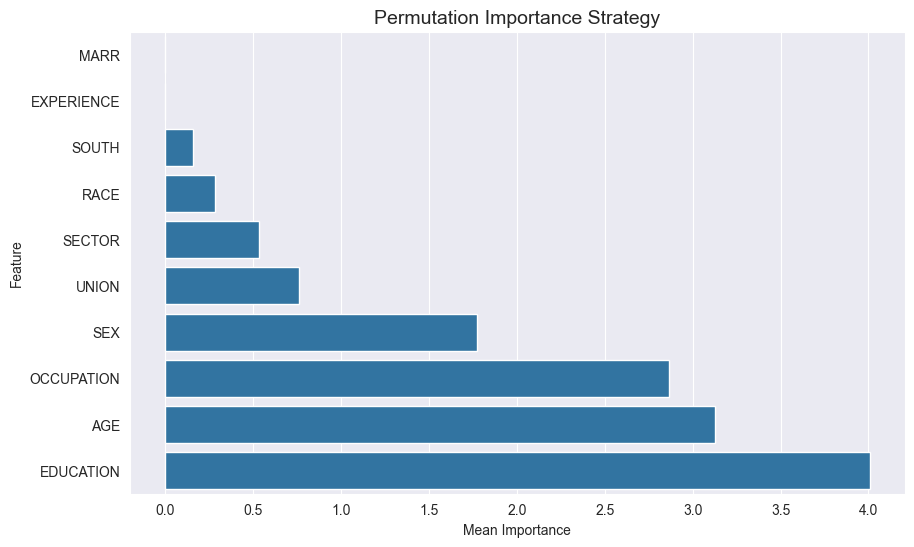

In [61]:
# Calculating permutation importance for each feature
feature_importance = permutation_importance(best_model_nMSE, X, y, random_state=42, scoring='neg_mean_squared_error')['importances_mean']
feature_name = X.columns.values

feature_name_ridge = best_model_nMSE[:-1].get_feature_names_out()

# Visualizing feature importance with a bar plot
plt.figure(figsize=(10,6))
plt.title('Permutation Importance Strategy', fontsize = 14)
sns.barplot(data = pd.DataFrame({'Importance': feature_importance, 'Feature':feature_name}).sort_values(by = 'Importance'),
            x = 'Importance',
            y = 'Feature'
)
plt.xlabel('Mean Importance')

### Model Coefficient Analysis
Examining the coefficients of the model to understand how each feature affects the predicted wage.
This provides insight into the direction and magnitude of each feature's impact.

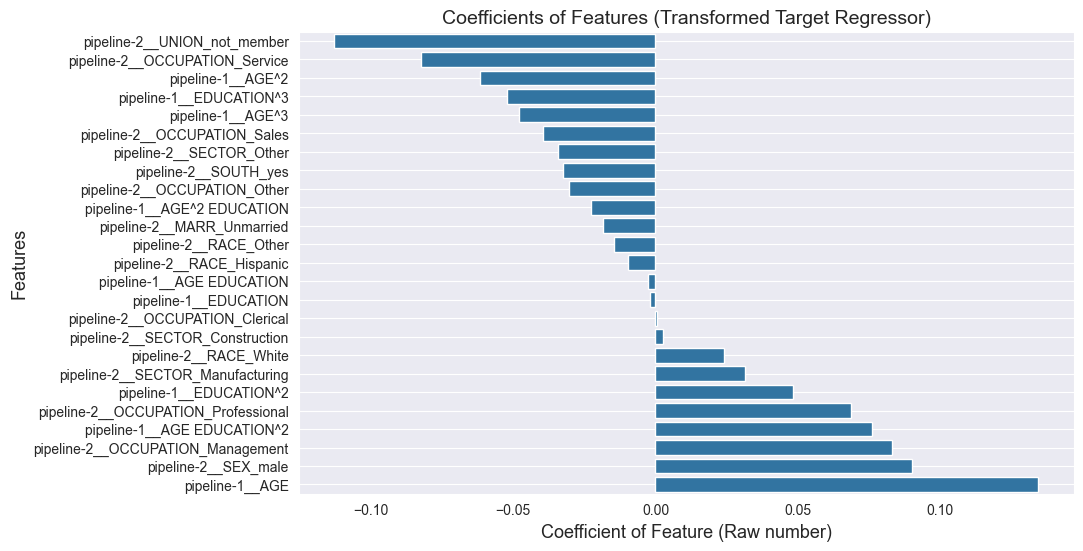

In [62]:
# Fitting the model and extracting coefficients
best_model_nMSE.fit(X_train,y_train)
dictionary_temp = {
    'Feature':best_model_nMSE.named_steps['preprocessor'].get_feature_names_out(),
    'Coefficient':best_model_nMSE.named_steps.ri.regressor_.coef_
}
coefs = pd.DataFrame(dictionary_temp)

# Visualizing the coefficients with a bar plot
plt.figure(figsize = (10,6))
plt.title('Coefficients of Features (Transformed Target Regressor)', fontsize = 14)
sns.barplot(data = coefs.sort_values(by = 'Coefficient'), x = 'Coefficient', y = 'Feature' )
plt.ylabel('Features', fontsize = 13)
plt.xlabel('Coefficient of Feature (Raw number)', fontsize = 13)
plt.grid();

### Model Diagnostic Visualizations
Using Yellowbrick to create diagnostic plots that help evaluate the model's performance.

In [63]:
# Importing Yellowbrick visualization tools
from yellowbrick.regressor import residuals_plot, PredictionError, alphas

#### Residuals Plot
Visualizing the residuals to check for patterns that might indicate model issues.

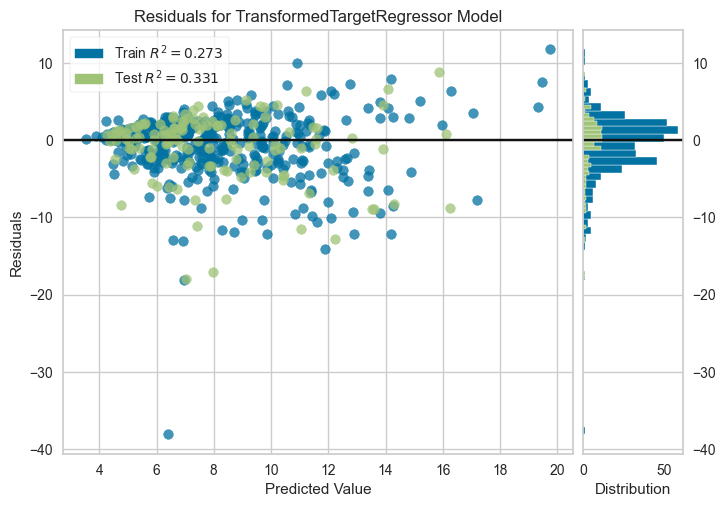

In [64]:
# Creating a residuals plot to examine model errors
viz = residuals_plot(best_model_nMSE, X_train, y_train, X_test, y_test)

#### Prediction Error Plot
Visualizing the relationship between actual and predicted values to assess model accuracy.

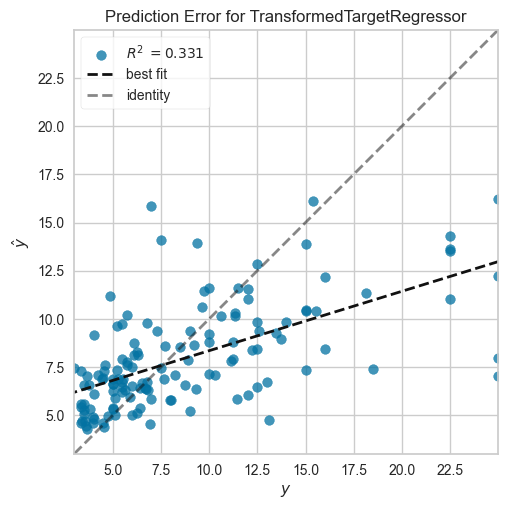

<Axes: title={'center': 'Prediction Error for TransformedTargetRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [65]:
# Creating a prediction error plot
visualizer = PredictionError(best_model_nMSE)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  